In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import holidays
from scipy.fftpack import fft#푸리에 변환을 위한 코드입니다.
from scipy.stats import boxcox#박스콕스 변환을 위한 코드임
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# ===== LightGBM 머신러닝 파이프라인 =====
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import optuna
from optuna.samplers import TPESampler



from sklearn.svm import SVR
#기타
import warnings
warnings.filterwarnings('ignore')

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_train = pd.read_csv("train_heat.csv")
df_test = pd.read_csv("test_heat.csv")
#열이름빼기
df_train.columns = df_train.columns.str.replace('train_heat.', '', regex=False)
#Unnamed:0제거
df_train = df_train.drop(columns=["Unnamed: 0"])
#test데이터 열이름 바꾸기
df_test.columns = [
    "tm", "branch_id", "ta", "wd", "ws",
    "rn_day", "rn_hr1", "hm", "si", "ta_chi","heat_demand"]

df_train = df_train[df_train['branch_id'] == 'B'].copy()
df_test = df_test[df_test['branch_id'] == 'B'].copy()


def calculate_summer_apparent_temp(ta, hm):
    """여름철 체감온도 계산"""
    try:
        tw = ta * np.arctan(0.151977 * np.sqrt(hm + 8.313659)) \
             + np.arctan(ta + hm) \
             - np.arctan(hm - 1.676331) \
             + 0.00391838 * hm**1.5 * np.arctan(0.023101 * hm) \
             - 4.686035
        return -0.2442 + 0.55399 * tw + 0.45535 * ta - 0.0022 * tw**2 + 0.00278 * tw * ta + 3.0
    except:
        return np.nan

def calculate_winter_apparent_temp(ta, ws):
    """겨울철 체감온도 계산"""
    try:
        v = ws * 3.6  # m/s → km/h
        return 13.12 + 0.6215 * ta - 11.37 * v**0.16 + 0.3965 * ta * v**0.16
    except:
        return np.nan

def add_apparent_temp_features(df):
    df['month'] = df['tm'].dt.month
    df['apparent_temp'] = df.apply(lambda row:
        calculate_summer_apparent_temp(row['ta'], row['hm']) if 5 <= row['month'] <= 9
        else calculate_winter_apparent_temp(row['ta'], row['ws']),
        axis=1
    )
    return df


def branchwise_svr_impute(df, col, time_col='tm'):
    df = df.copy()
    # 시간 컬럼을 숫자형으로 변환 (timestamp, 초 단위)
    df['_time_num'] = pd.to_datetime(df[time_col]).astype(np.int64) // 10**9
    # branch별로 SVR 보간
    def impute_group(g):
        return svr_impute_series(g[col], g['_time_num'])
    # apply 결과를 원래 인덱스에 맞게 할당
    df[col] = df.groupby('branch_id', group_keys=False).apply(impute_group)
    df = df.drop(columns=['_time_num'])
    return df


def preprocess_weather_data(df):
    # 날짜 변환
    df['tm'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
    # 1. si: 08~18시가 아닐 때 -99는 0으로
    mask_outside_8_to_18 = (~df['tm'].dt.hour.between(8, 18)) & (df['si'] == -99)
    df.loc[mask_outside_8_to_18, 'si'] = 0

    # 2. wd에서 9.9는 NaN으로
    df['wd'] = df['wd'].replace(9.9, np.nan)

    # 3. -99 처리
    df.replace(-99, np.nan, inplace=True)


    # SVR 보간
    df = df.sort_values(['branch_id', 'tm'])

    numeric_cols = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'heat_demand']

    for branch in df['branch_id'].unique():
        print(f"   🏢 브랜치 {branch} SVR 보간 중...", end=" ")
        
        branch_mask = df['branch_id'] == branch
        branch_data = df[branch_mask].copy()

        # 시간 특성 생성
        branch_data['hour'] = branch_data['tm'].dt.hour
        branch_data['day_of_year'] = branch_data['tm'].dt.dayofyear
        branch_data['month'] = branch_data['tm'].dt.month

        for col in numeric_cols:
            if col in branch_data.columns:
                missing_mask = branch_data[col].isna()

                if missing_mask.sum() > 0:
                    train_mask = ~missing_mask

                    # 예측할 데이터 준비
                    X_train = branch_data.loc[train_mask, ['hour', 'day_of_year', 'month']].values
                    y_train = branch_data.loc[train_mask, col].values
                    X_pred = branch_data.loc[missing_mask, ['hour', 'day_of_year', 'month']].values

                    try:
                        scaler_X = StandardScaler()
                        scaler_y = StandardScaler()

                        X_train_scaled = scaler_X.fit_transform(X_train)
                        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

                        svr = SVR(kernel='rbf', C=1.0, gamma='scale')
                        svr.fit(X_train_scaled, y_train_scaled)

                        X_pred_scaled = scaler_X.transform(X_pred)
                        y_pred_scaled = svr.predict(X_pred_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

                        # 보간 결과 반영
                        df.loc[branch_mask & missing_mask, col] = y_pred

                    except Exception as e:
                        print(f"\n   ⚠️ {col} SVR 실패 → 선형 보간 대체")
                        df.loc[branch_mask, col] = df.loc[branch_mask, col].interpolate(method='linear')

                # 남은 결측 ffill/bfill로 제거
                df.loc[branch_mask, col] = df.loc[branch_mask, col].fillna(method='ffill').fillna(method='bfill')

        print("✅")

    print("🎉 SVR 보간 완료 (조건 없이 전부 시도)")
    #보간후 음수나올 가능성존재
    df.loc[df['ta'] < 0, 'ta'] = 0
    df.loc[df['ws'] < 0, 'ws'] = 0

    # 📌 파생 변수 생성
    df['year'] = df['tm'].dt.year
    df['month'] = df['tm'].dt.month
    df['day'] = df['tm'].dt.day
    df['hour'] = df['tm'].dt.hour
    df['date'] = df['tm'].dt.date
    df['weekday'] = df['tm'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

    # 🇰🇷 한국 공휴일
    kr_holidays = holidays.KR()
    df['is_holiday'] = df['tm'].dt.date.apply(lambda x: int(x in kr_holidays))

    # 🕒 시간 지연
    for lag in [1, 2, 3]:
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')['ta'].shift(lag)
        df[f'ta_lag_{lag}'] = df.groupby('branch_id')[f'ta_lag_{lag}'].transform(
        lambda x: x.fillna(method='bfill'))
    # 🔥 HDD / CDD
    df['HDD18'] = np.maximum(0, 18 - df['ta'])
    #df['CDD18'] = np.maximum(0, df['ta'] - 18)
    df['HDD20'] = np.maximum(0, 20 - df['ta'])
    #df['CDD20'] = np.maximum(0, df['ta'] - 20)

    #직접만든 체감온도
    df = add_apparent_temp_features(df)


    # 지점별 온도 편차
    branch_mean = df.groupby('branch_id')['ta'].transform('mean')
    df['branch_temp_abs_deviation'] = np.abs(df['ta'] - branch_mean)



    # 이동 평균 (3시간 단위 최대 24시간 = 8개)
    for n in [3, 6, 9, 12, 15, 18, 21, 24]:
        df[f'ta_3h_avg_{n}'] = df.groupby('branch_id')['ta'].transform(lambda x: x.rolling(n, min_periods=1).mean())

    # 불쾌지수
    df['DCI'] = 0.81 * df['ta'] + 0.01 * df['hm'] * (0.99 * df['ta'] - 14.3) + 46.3

    # 풍속 냉지수 (wchi)
    ws_kmh = df['ws'] * 3.6  # m/s -> km/h 변환
    df['wchi'] = 13.12 + 0.6215 * df['ta'] - 11.37 * ws_kmh**0.16 + 0.3965 * df['ta'] * ws_kmh**0.16

     # 풍속 고려 체감온도 (wind chill)
    df['wind_chill'] = 13.12 + 0.6215 * df['ta'] - 11.37 * df['ws']**0.16 + 0.3965 * df['ta'] * df['ws']**0.16

    # 실효온도
    df['e'] = (df['hm'] / 100) * 6.105 * np.exp((17.27 * df['ta']) / (237.7 + df['ta']))
    df['atemphi'] = df['ta'] + 0.33 * df['e'] - 0.70 * df['ws'] - 4.00

    # 주기성 인코딩
    df['dayofyear'] = df['tm'].dt.dayofyear
    df['dayofmonth'] = df['tm'].dt.day
    df['weekofyear'] = df['tm'].dt.isocalendar().week.astype(int)

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)

    # 하루 5구간
    def time_slot(h): return int(h // 5)
    df['hour_slot_5'] = df['hour'].apply(time_slot)

    def compute_fft_feature(series, n=10):
        fft_vals = np.abs(fft(series.fillna(0)))
        # 인덱스 이름을 명확히 지정
        s = pd.Series(fft_vals[:n], index=[f'fft_{i}' for i in range(n)])
        return s

    def compute_fft_feature(series, n=10):
        fft_vals = np.abs(fft(series.fillna(0)))
        s = pd.Series(fft_vals[:n], index=pd.Index([f'fft_{i}' for i in range(n)], name='fft_idx'))
        return s

    fft_cols = ['ta', 'hm', 'ws', 'ta_chi', 'apparent_temp']
    fft_features = []
    branch_ids = df['branch_id'].unique()
    fft_feature_dict = {bid: {} for bid in branch_ids}
    for col in fft_cols:
        if col not in df.columns:
            continue
        for branch_id in branch_ids:
            arr = df.loc[df['branch_id'] == branch_id, col].fillna(0).values
            fft_vals = np.abs(fft(arr))[:10]
            for i, val in enumerate(fft_vals):
                fft_feature_dict[branch_id][f'Nph_{col}_{i}'] = val
                
    # DataFrame으로 변환
    fft_features_df = pd.DataFrame.from_dict(fft_feature_dict, orient='index')
    # 원본 df와 merge
    df = df.merge(fft_features_df, left_on='branch_id', right_index=True, how='left')

    # 기온 차분
    df['ta_diff_6h'] = df.groupby('branch_id')['ta'].diff(6).bfill()
    df['ta_diff_12h'] = df.groupby('branch_id')['ta'].diff(12).bfill()
    df['ta_diff_24h'] = df.groupby('branch_id')['ta'].diff(24).bfill()

    # 일교차
    df['day_ta_max'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('max')
    df['day_ta_min'] = df.groupby(['branch_id', df['tm'].dt.date])['ta'].transform('min')
    df['daily_range'] = df['day_ta_max'] - df['day_ta_min']

    # 일교차 변화량
    df['daily_range_shift'] = df.groupby('branch_id')['daily_range'].shift(1).bfill()

    # 피크타임1
    df['peak_time1'] = 0
    df.loc[(df['hour'] >= 0) & (df['hour'] <= 6), 'peak_time1'] = 1
    df.loc[(df['hour'] > 6) & (df['hour'] <= 11), 'peak_time1'] = 2
    df.loc[(df['hour'] > 11) & (df['hour'] <= 18), 'peak_time1'] = 3
    df.loc[(df['hour'] > 18) & (df['hour'] <= 23), 'peak_time1'] = 4

    # 피크타임2
    df['peak_time2'] = 0
    df.loc[(df['hour'] >= 2) & (df['hour'] <= 10), 'peak_time2'] = 1


    # heating season
    df['heating_season'] = df['month'].isin([10,11,12,1, 2, 3,4]).astype(int)

    # 온도 범주화
    df['temp_category20'] = pd.cut(df['ta'], bins=[-np.inf, 20, np.inf], labels=['low', 'high'])
    df['temp_category18'] = pd.cut(df['ta'], bins=[-np.inf, 18, np.inf], labels=['low', 'high'])
    df['temp_category16'] = pd.cut(df['ta'], bins=[-np.inf, 16, np.inf], labels=['low', 'high'])

    # 오전/오후
    df['afternoon'] = (df['hour'] >= 12).astype(int)

    # 계절
    def get_season(month):
        return {
            12: 'winter', 1: 'winter', 2: 'winter',
            3: 'spring', 4: 'spring', 5: 'spring',
            6: 'summer', 7: 'summer', 8: 'summer',
            9: 'fall', 10: 'fall', 11: 'fall'
        }.get(month, 'unknown')
    df['season'] = df['month'].apply(get_season)

    # 한파 주의보/경보
    df['cold_watch'] = (df['ta'] <= -12).astype(int)  # 주의보
    df['cold_warning'] = (df['ta'] <= -15).astype(int)  # 경보


    # 변환 대상 변수
    col = 'ta'
    '''
    df['ta_boxcox'] = np.nan
    df['ta_boxcox_lambda'] = np.nan
    df['ta_boxcox_shift'] = np.nan  # shift 값도 저장
    for branch, group in df.groupby('branch_id'):
        col = 'ta'
        min_val = group[col].min()
        if min_val <= 0:
            shift = abs(min_val) + 1e-4
        else:
            shift = 0
        shifted = group[col] + shift
        shifted = shifted.dropna()
        if shifted.nunique() > 1 and len(shifted) >= 2:
            transformed, fitted_lambda = boxcox(shifted)
            df.loc[shifted.index, 'ta_boxcox'] = transformed
            df.loc[shifted.index, 'ta_boxcox_lambda'] = fitted_lambda
            df.loc[shifted.index, 'ta_boxcox_shift'] = shift
        else:
            df.loc[group.index, 'ta_boxcox'] = np.nan
            df.loc[group.index, 'ta_boxcox_lambda'] = np.nan
            df.loc[group.index, 'ta_boxcox_shift'] = shift


    '''
    df = df.drop(columns=['date'])



    return df
#상호작용 처리못함
#군집화된 전처리 못함


#정규화 일단 min max +원핫인코딩
def scale_encode(df):
    cat_cols = [
         'peak_time1', 'peak_time2', 'heating_season',
        'temp_category16', 'temp_category18', 'temp_category20',
        'afternoon', 'season','month','hour','day'
    ]

    # 범주형 변수 category화
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # 원-핫 인코딩
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # 연속형 변수만 추출 (타겟, 날짜 등 제외)
    exclude_cols = ['heat_demand', 'peak_time1', 'peak_time2', 'heating_season',
        'temp_category16', 'temp_category18', 'temp_category20','afternoon', 'season','month','hour','day']
    num_cols = [col for col in df.columns
                if (df[col].dtype in [np.float64, np.int64]) and (col not in exclude_cols)]

    # MinMaxScaler 적용
    scaler = MinMaxScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])


    return df



df_train = preprocess_weather_data(df_train)
df_test = preprocess_weather_data(df_test)


df_train = scale_encode(df_train)
df_test = scale_encode(df_test)

df_train.to_csv('df_train_prescale.csv', index=True)
df_test.to_csv('df_test_prescale.csv', index=True)

   🏢 브랜치 B SVR 보간 중... ✅
🎉 SVR 보간 완료 (조건 없이 전부 시도)
   🏢 브랜치 B SVR 보간 중... 
   ⚠️ heat_demand SVR 실패 → 선형 보간 대체
✅
🎉 SVR 보간 완료 (조건 없이 전부 시도)


In [3]:
df_train = pd.read_csv('df_train_prescale.csv')
df=df_train.copy()
df_train = df[df['year'] <= 2022]
df_test = df[df['year'] >= 2023]
df_train = df_train.sort_values(['branch_id', 'tm'])
df_test = df_test.sort_values(['branch_id', 'tm'])
df_train = df_train.drop(columns=['year'])
df_train = df_train.drop(columns=['Unnamed: 0'])
df_test = df_test.drop(columns=['year'])
df_test = df_test.drop(columns=['Unnamed: 0'])
df_train = df_train.set_index('tm')
df_test = df_test.set_index('tm')
df_train = df_train.sort_index()
df_test = df_test.sort_index()

In [4]:
def run_3fold_pipeline_with_residual(df_train, df_test, target_col='heat_demand'):
    features = [col for col in df_train.columns if col != target_col]
    X = df_train[features]
    y = df_train[target_col]

    n = len(df_train)
    fold_size = n // 3

    val_rmses = []
    test_preds = []

    print(f"전체 데이터 길이: {n}, Fold 크기: {fold_size}\n")

    for fold in range(2):  # Fold 0, 1 수행 (3번째는 테스트용 데이터 분리)
        train_end = fold_size * (fold + 1)
        val_end = fold_size * (fold + 2)

        X_train = X.iloc[:train_end]
        y_train = y.iloc[:train_end]
        X_val = X.iloc[train_end:val_end]
        y_val = y.iloc[train_end:val_end]

        print(f"===== Fold {fold+1} =====")
        print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

        # 1) LightGBM 베이지안 최적화 함수
        def lgb_objective(trial):
            params = {
                'objective': 'regression',
                'metric': 'rmse',
                'boosting_type': 'gbdt',
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'num_leaves': trial.suggest_int('num_leaves', 10, 300),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
                'n_estimators': 1000,
                'random_state': 42,
                'n_jobs': -1
            }
            model = lgb.LGBMRegressor(**params)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(y_val, val_pred))

        lgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        lgb_study.optimize(lgb_objective, n_trials=20, show_progress_bar=True)

        best_lgb_params = lgb_study.best_params
        best_lgb_params.update({
            'objective': 'huber',
            'metric': 'rmse',
            'boosting_type': 'gbdt',
            'n_estimators': 1000,
            'random_state': 42,
            'n_jobs': -1
        })

        # 2) LightGBM 최적 모델 학습
        lgb_model = lgb.LGBMRegressor(**best_lgb_params)
        lgb_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(100)]
        )

        val_pred_lgb = lgb_model.predict(X_val)
        val_rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
        print(f"LightGBM Fold {fold+1} Validation RMSE: {val_rmse_lgb:.4f}")

        # 3) 잔차 계산
        residual_train = y_train - lgb_model.predict(X_train)
        residual_val = y_val - val_pred_lgb

        # 4) XGBoost 베이지안 최적화 함수
        def xgb_objective(trial):
            params = {
                'objective': 'reg:squarederror',  # Huber-like loss
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'max_depth': trial.suggest_int('max_depth', 2, 10),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
                'random_state': 42,
                'n_jobs': -1
            }
            model = xgb.XGBRegressor(**params)
            model.fit(
                X_train, residual_train,
                eval_set=[(X_val, residual_val)],
                verbose=0
            )
            val_pred = model.predict(X_val)
            return np.sqrt(mean_squared_error(residual_val, val_pred))

        xgb_study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        xgb_study.optimize(xgb_objective, n_trials=20, show_progress_bar=True)

        best_xgb_params = xgb_study.best_params
        best_xgb_params.update({
            'objective': 'reg:pseudohubererror',
            'random_state': 42,
            'n_jobs': -1
        })

        # 5) XGBoost 최적 모델 학습 (잔차 예측용)
        xgb_model = xgb.XGBRegressor(**best_xgb_params)
        xgb_model.fit(
            X_train, residual_train,
            eval_set=[(X_val, residual_val)],
            verbose=100
        )

        val_pred_residual = xgb_model.predict(X_val)
        val_pred_final = val_pred_lgb + val_pred_residual
        val_rmse_final = np.sqrt(mean_squared_error(y_val, val_pred_final))
        print(f"Residual Stacking Fold {fold+1} Validation RMSE: {val_rmse_final:.4f}")

        val_rmses.append(val_rmse_final)

        # 테스트는 마지막에 평균 예측 위해 저장
        test_pred_lgb = lgb_model.predict(df_test[features])
        test_pred_residual = xgb_model.predict(df_test[features])
        test_pred_fold = test_pred_lgb + test_pred_residual
        test_preds.append(test_pred_fold)

        print("-----------------------------")

    avg_val_rmse = np.mean(val_rmses)
    avg_test_pred = np.mean(test_preds, axis=0)

    print(f"\n최종 평균 Validation RMSE: {avg_val_rmse:.4f}")

    df_test[target_col] = avg_test_pred

    return {
        'val_rmse': avg_val_rmse,
        'val_rmses': val_rmses,   # 추가!
        'test_pred': avg_test_pred,
        'test_index': df_test.index
    }

[I 2025-06-22 03:18:37,479] A new study created in memory with name: no-name-b7c84d77-6ea8-4567-9890-14d02d560f88


전체 데이터 길이: 17519, Fold 크기: 5839

===== Fold 1 =====
Train size: 5839, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 0. Best value: 91.1922:   5%|▌         | 1/20 [00:00<00:07,  2.50it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 91.1922:  10%|█         | 2/20 [00:00<00:05,  3.59it/s]

[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2

Best trial: 0. Best value: 91.1922:  15%|█▌        | 3/20 [00:01<00:07,  2.38it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 91.1922:  20%|██        | 4/20 [00:01<00:05,  3.07it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 89.0772:  25%|██▌       | 5/20 [00:01<00:05,  2.50it/s]

[I 2025-06-22 03:18:39,373] Trial 4 finished with value: 89.07720211486959 and parameters: {'learning_rate': 0.028180680291847244, 'num_leaves': 38, 'max_depth': 11, 'min_data_in_leaf': 94, 'feature_fraction': 0.47322294090686734, 'bagging_fraction': 0.6971061460667621, 'bagging_freq': 1, 'reg_alpha': 9.093204020787821, 'reg_lambda': 2.587799816000169}. Best is trial 4 with value: 89.07720211486959.
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] feature_fraction is set=0.5109126733153162, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5109126733153162
[LightGBM] [Warning] bagging_fraction is set=0.9817507766587351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817507766587351
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samp

Best trial: 4. Best value: 89.0772:  30%|███       | 6/20 [00:02<00:05,  2.50it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 89.0772:  35%|███▌      | 7/20 [00:02<00:05,  2.51it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 89.0772:  40%|████      | 8/20 [00:03<00:07,  1.66it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 89.0772:  45%|████▌     | 9/20 [00:04<00:08,  1.33it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 89.0772:  50%|█████     | 10/20 [00:05<00:05,  1.69it/s]

[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.5951099932160482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5951099932160482
[LightGBM] [Warning] bagging_fraction is set=0.8377637070028385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8377637070028385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8696
[LightGBM] [Info] Number of data points in the train set: 5839, number of used features: 120
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] feature_fraction is set=0.59510999321

Best trial: 4. Best value: 89.0772:  55%|█████▌    | 11/20 [00:05<00:04,  1.96it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[84]	valid_0's rmse: 129.484
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.7217131532186557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7217131532186557
[LightGBM] [Warning] bagging_fraction is set=0.7644281754688748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7644281754688748
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 03:18:42,850] Trial 10 finished with value: 129.48404672586716 and parameters: {'learning_rate': 0.24893231508461813, 'num_leaves': 11, 'max_depth': 7, 'min_data_in_l

Best trial: 4. Best value: 89.0772:  55%|█████▌    | 11/20 [00:06<00:04,  1.96it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 4. Best value: 89.0772:  60%|██████    | 12/20 [00:06<00:04,  1.68it/s]

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.41642061982236134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41642061982236134
[LightGBM] [Warning] bagging_fraction is set=0.8623398761202057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8623398761202057
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.41642061982236134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41642061982236134
[LightGBM] [Warning] bagging_fraction is set=0.8623398761202057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8623398761202057
[LightGBM] [Warning] bagging_freq is s

Best trial: 4. Best value: 89.0772:  65%|██████▌   | 13/20 [00:06<00:04,  1.69it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 13. Best value: 87.1559:  70%|███████   | 14/20 [00:07<00:03,  1.52it/s]

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.4015540311493189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4015540311493189
[LightGBM] [Warning] bagging_fraction is set=0.8888702314029386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8888702314029386
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 03:18:45,027] Trial 13 finished with value: 87.15589696642789 and parameters: {'learning_rate': 0.017032717582053745, 'num_leaves': 205, 'max_depth': 15, 'min_data_in_leaf': 200, 'feature_fraction': 0.4015540311493189, 'bagging_fraction': 0.8888702314029386, 'bagging_freq': 2, 'reg_alpha': 6.319917485832356, 'reg_lambda': 3.336671721126814}. Best is trial 13 with value: 87.15589696642789.
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_s

Best trial: 13. Best value: 87.1559:  75%|███████▌  | 15/20 [00:08<00:03,  1.28it/s]

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] feature_fraction is set=0.6758022628419735, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6758022628419735
[LightGBM] [Warning] bagging_fraction is set=0.9640877674690975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9640877674690975
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[I 2025-06-22 03:18:46,089] Trial 14 finished with value: 114.17407060659595 and parameters: {'learning_rate': 0.010457065772553623, 'num_leaves': 136, 'max_depth': 15, 'min_data_in_leaf': 200, 'feature_fraction': 0.6758022628419735, 'bagging_fraction': 0.9640877674690975, 'bagging_freq': 3, 'reg_alpha': 4.531939007720673, 'reg_lambda': 3.208501786198173}. Best is trial 13 with value: 87.15589696642789.
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_s

Best trial: 15. Best value: 82.1519:  80%|████████  | 16/20 [00:10<00:04,  1.12s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[548]	valid_0's rmse: 82.1519
[LightGBM] [Warning] min_data_in_le

Best trial: 15. Best value: 82.1519:  85%|████████▌ | 17/20 [00:13<00:05,  1.81s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.4022940396210904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4022940396210904
[LightGBM] [Warning] bagging_fraction is set=0.8722023075149075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8722023075149075
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 03:18:51,426] Trial 16 finished with value: 82.39369989740463 and parameters: {'learning_rate': 0.01768129648932595, 'num_leaves': 160, 'max_depth': 7, 'min_data_in_leaf': 10, 'feature_fraction': 0.4022940396210904, 'bagging_fraction': 0.8722023075149075, 'bagging_freq': 2, 'reg_alpha': 4.380260969709104, 'reg_lambda': 0.13179214380923554}. Best is trial 15 with value: 82.15193416095741.
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_sampl

Best trial: 15. Best value: 82.1519:  90%|█████████ | 18/20 [00:15<00:03,  1.75s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 15. Best value: 82.1519:  95%|█████████▌| 19/20 [00:18<00:02,  2.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6018664528876175, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6018664528876175
[LightGBM] [Warning] bagging_fraction is set=0.913328604638754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.913328604638754
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 03:18:56,471] Trial 18 finished with value: 101.84692141430497 and parameters: {'learning_rate': 0.013224587815606684, 'num_leaves': 61, 'max_depth': 7, 'min_data_in_leaf': 10, 'feature_fraction': 0.6018664528876175, 'bagging_fraction': 0.913328604638754, 'bagging_freq': 2, 'reg_alpha': 0.901740529474278, 'reg_lambda': 1.3791290236962879}. Best is trial 15 with value: 82.15193416095741.
[LightGBM] [Warning] min_data_in_leaf is set=57, min_child_samples=

Best trial: 15. Best value: 82.1519: 100%|██████████| 20/20 [00:19<00:00,  1.02it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-22 03:18:58,712] A new study created in memory with name: no-name-0441f5b7-fc06-43ca-81a0-c634fd98c443


LightGBM Fold 1 Validation RMSE: 210.8490
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.4048236215996866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4048236215996866
[LightGBM] [Warning] bagging_fraction is set=0.7794895923263812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7794895923263812
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


Best trial: 0. Best value: 109.776:   5%|▌         | 1/20 [00:04<01:18,  4.13s/it]

[I 2025-06-22 03:19:02,841] Trial 0 finished with value: 109.77646494224297 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 109.77646494224297.


Best trial: 0. Best value: 109.776:  10%|█         | 2/20 [00:12<02:04,  6.92s/it]

[I 2025-06-22 03:19:11,710] Trial 1 finished with value: 155.06767185449374 and parameters: {'n_estimators': 880, 'learning_rate': 0.07725378389307355, 'max_depth': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 0 with value: 109.77646494224297.


Best trial: 2. Best value: 104.339:  15%|█▌        | 3/20 [00:14<01:13,  4.30s/it]

[I 2025-06-22 03:19:12,896] Trial 2 finished with value: 104.33927700452058 and parameters: {'n_estimators': 263, 'learning_rate': 0.018659959624904916, 'max_depth': 4, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 2.9122914019804194, 'reg_lambda': 6.118528947223795}. Best is trial 2 with value: 104.33927700452058.


Best trial: 2. Best value: 104.339:  20%|██        | 4/20 [00:15<00:48,  3.04s/it]

[I 2025-06-22 03:19:14,013] Trial 3 finished with value: 123.95568375743092 and parameters: {'n_estimators': 225, 'learning_rate': 0.027010527749605478, 'max_depth': 5, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 1.9967378215835974, 'reg_lambda': 5.142344384136116}. Best is trial 2 with value: 104.33927700452058.


Best trial: 2. Best value: 104.339:  25%|██▌       | 5/20 [00:19<00:51,  3.43s/it]

[I 2025-06-22 03:19:18,128] Trial 4 finished with value: 106.39268452873368 and parameters: {'n_estimators': 633, 'learning_rate': 0.011711509955524094, 'max_depth': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 9.488855372533333, 'reg_lambda': 9.656320330745594}. Best is trial 2 with value: 104.33927700452058.


Best trial: 5. Best value: 97.9657:  30%|███       | 6/20 [00:22<00:44,  3.19s/it]

[I 2025-06-22 03:19:20,843] Trial 5 finished with value: 97.9657103666459 and parameters: {'n_estimators': 828, 'learning_rate': 0.028180680291847244, 'max_depth': 2, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 1.2203823484477883, 'reg_lambda': 4.951769101112702}. Best is trial 5 with value: 97.9657103666459.


Best trial: 6. Best value: 89.9022:  35%|███▌      | 7/20 [00:22<00:30,  2.35s/it]

[I 2025-06-22 03:19:21,475] Trial 6 finished with value: 89.90224889573751 and parameters: {'n_estimators': 130, 'learning_rate': 0.22038218939289875, 'max_depth': 4, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 5.200680211778108, 'reg_lambda': 5.4671027934327965}. Best is trial 6 with value: 89.90224889573751.


Best trial: 6. Best value: 89.9022:  40%|████      | 8/20 [00:25<00:29,  2.50s/it]

[I 2025-06-22 03:19:24,280] Trial 7 finished with value: 155.53674730014606 and parameters: {'n_estimators': 266, 'learning_rate': 0.27051668818999286, 'max_depth': 8, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 5.978999788110851, 'reg_lambda': 9.218742350231167}. Best is trial 6 with value: 89.90224889573751.


Best trial: 6. Best value: 89.9022:  45%|████▌     | 9/20 [00:26<00:21,  1.92s/it]

[I 2025-06-22 03:19:24,948] Trial 8 finished with value: 93.5769101074259 and parameters: {'n_estimators': 179, 'learning_rate': 0.01947558230629543, 'max_depth': 2, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 6 with value: 89.90224889573751.


Best trial: 6. Best value: 89.9022:  50%|█████     | 10/20 [00:28<00:21,  2.12s/it]

[I 2025-06-22 03:19:27,496] Trial 9 finished with value: 133.38640299808225 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 6, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 0.7455064367977082, 'reg_lambda': 9.868869366005173}. Best is trial 6 with value: 89.90224889573751.


Best trial: 6. Best value: 89.9022:  55%|█████▌    | 11/20 [00:36<00:34,  3.89s/it]

[I 2025-06-22 03:19:35,397] Trial 10 finished with value: 114.6415601701493 and parameters: {'n_estimators': 562, 'learning_rate': 0.11041930924484174, 'max_depth': 10, 'subsample': 0.9352468198873466, 'colsample_bytree': 0.6363434386005423, 'reg_alpha': 5.4094390817554805, 'reg_lambda': 3.613119964418094}. Best is trial 6 with value: 89.90224889573751.


Best trial: 6. Best value: 89.9022:  60%|██████    | 12/20 [00:37<00:22,  2.86s/it]

[I 2025-06-22 03:19:35,897] Trial 11 finished with value: 107.47242795828767 and parameters: {'n_estimators': 105, 'learning_rate': 0.12587933563680412, 'max_depth': 2, 'subsample': 0.6684237691066285, 'colsample_bytree': 0.8078685206868834, 'reg_alpha': 4.345791428848278, 'reg_lambda': 7.304810625034938}. Best is trial 6 with value: 89.90224889573751.


Best trial: 6. Best value: 89.9022:  65%|██████▌   | 13/20 [00:37<00:15,  2.17s/it]

[I 2025-06-22 03:19:36,503] Trial 12 finished with value: 92.15150969456596 and parameters: {'n_estimators': 127, 'learning_rate': 0.047796322540107704, 'max_depth': 3, 'subsample': 0.8836877669280698, 'colsample_bytree': 0.640535380158451, 'reg_alpha': 3.744654217248584, 'reg_lambda': 7.793237299326467}. Best is trial 6 with value: 89.90224889573751.


Best trial: 6. Best value: 89.9022:  70%|███████   | 14/20 [00:39<00:12,  2.02s/it]

[I 2025-06-22 03:19:38,166] Trial 13 finished with value: 96.42062259961237 and parameters: {'n_estimators': 389, 'learning_rate': 0.050724306705479366, 'max_depth': 4, 'subsample': 0.8859620061900357, 'colsample_bytree': 0.6248773175738308, 'reg_alpha': 6.344571403755403, 'reg_lambda': 7.119778022134117}. Best is trial 6 with value: 89.90224889573751.


Best trial: 6. Best value: 89.9022:  75%|███████▌  | 15/20 [00:42<00:11,  2.28s/it]

[I 2025-06-22 03:19:41,038] Trial 14 finished with value: 113.94150027766803 and parameters: {'n_estimators': 686, 'learning_rate': 0.047607851558822294, 'max_depth': 4, 'subsample': 0.88472119699652, 'colsample_bytree': 0.7954038992607805, 'reg_alpha': 4.128414060528098, 'reg_lambda': 4.00955969682044}. Best is trial 6 with value: 89.90224889573751.


Best trial: 15. Best value: 80.1626:  80%|████████  | 16/20 [00:42<00:07,  1.76s/it]

[I 2025-06-22 03:19:41,591] Trial 15 finished with value: 80.16262145986151 and parameters: {'n_estimators': 117, 'learning_rate': 0.18768371344111617, 'max_depth': 3, 'subsample': 0.9940380700568975, 'colsample_bytree': 0.5026429879660299, 'reg_alpha': 7.468762102442304, 'reg_lambda': 6.932931039106097}. Best is trial 15 with value: 80.16262145986151.


Best trial: 15. Best value: 80.1626:  85%|████████▌ | 17/20 [00:44<00:05,  1.74s/it]

[I 2025-06-22 03:19:43,301] Trial 16 finished with value: 104.60393392068367 and parameters: {'n_estimators': 327, 'learning_rate': 0.16643823494261317, 'max_depth': 5, 'subsample': 0.9870988168339239, 'colsample_bytree': 0.5175850005881201, 'reg_alpha': 7.366028622758963, 'reg_lambda': 6.025790026749813}. Best is trial 15 with value: 80.16262145986151.


Best trial: 15. Best value: 80.1626:  90%|█████████ | 18/20 [00:46<00:03,  1.81s/it]

[I 2025-06-22 03:19:45,276] Trial 17 finished with value: 84.93741712079715 and parameters: {'n_estimators': 501, 'learning_rate': 0.1579451423105741, 'max_depth': 3, 'subsample': 0.934274193553333, 'colsample_bytree': 0.5641231366238806, 'reg_alpha': 7.513323115188119, 'reg_lambda': 2.7504063681238424}. Best is trial 15 with value: 80.16262145986151.


Best trial: 15. Best value: 80.1626:  95%|█████████▌| 19/20 [00:49<00:02,  2.05s/it]

[I 2025-06-22 03:19:47,872] Trial 18 finished with value: 92.31597228533771 and parameters: {'n_estimators': 749, 'learning_rate': 0.08407654179943178, 'max_depth': 3, 'subsample': 0.9347072979669518, 'colsample_bytree': 0.5004556151238979, 'reg_alpha': 9.817361673516054, 'reg_lambda': 2.0110583066296575}. Best is trial 15 with value: 80.16262145986151.


Best trial: 19. Best value: 77.5285: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]

[I 2025-06-22 03:19:51,257] Trial 19 finished with value: 77.52848736430317 and parameters: {'n_estimators': 951, 'learning_rate': 0.166960060173892, 'max_depth': 3, 'subsample': 0.9904227850611723, 'colsample_bytree': 0.5716849120038083, 'reg_alpha': 7.326553897715631, 'reg_lambda': 2.7833734128123315}. Best is trial 19 with value: 77.52848736430317.
[0]	validation_0-mphe:131.00468


[100]	validation_0-mphe:57.60563
[200]	validation_0-mphe:56.97366
[300]	validation_0-mphe:56.46177
[400]	validation_0-mphe:57.01234
[500]	validation_0-mphe:56.52961
[600]	validation_0-mphe:56.51190
[700]	validation_0-mphe:56.28058
[800]	validation_0-mphe:56.21538
[900]	validation_0-mphe:56.26488
[950]	validation_0-mphe:56.20682
Residual Stacking Fold 1 Validation RMSE: 81.9819
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.4048236215996866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4048236215996866
[LightGBM] [Warning] bagging_fraction is set=0.7794895923263812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7794895923263812
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2025-06-22 03:19:55,035] A new study created in memory with name: no-name-5024bda0-c0d1-4a0e-ba5c-7cd0bd02858d


-----------------------------
===== Fold 2 =====
Train size: 11678, Validation size: 5839


  0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=124, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=124
[LightGBM] [Warning] feature_fraction is set=0.4936111842654619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4936111842654619
[LightGBM] [Warning] bagging_fraction is set=0.49359671220172163, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49359671220172163
[LightGBM] [Warning] bagging_freq is s

Best trial: 0. Best value: 29.4814:   5%|▌         | 1/20 [00:00<00:14,  1.28it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iter

Best trial: 0. Best value: 29.4814:  10%|█         | 2/20 [00:01<00:09,  1.87it/s]

Early stopping, best iteration is:
[101]	valid_0's rmse: 30.0418
[LightGBM] [Warning] min_data_in_leaf is set=168, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=168
[LightGBM] [Warning] feature_fraction is set=0.5274034664069657, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5274034664069657
[LightGBM] [Warning] bagging_fraction is set=0.5090949803242604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5090949803242604
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 03:19:56,179] Trial 1 finished with value: 30.041795051647313 and parameters: {'learning_rate': 0.11114989443094977, 'num_leaves': 15, 'max_depth': 15, 'min_data_in_leaf': 168, 'feature_fraction': 0.5274034664069657, 'bagging_fraction': 0.5090949803242604, 'bagging_freq': 2, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 5.247564316322379}. Best is trial 0 with value: 29.48141355966875

Best trial: 0. Best value: 29.4814:  15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.4814:  20%|██        | 4/20 [00:02<00:09,  1.66it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.4814:  25%|██▌       | 5/20 [00:03<00:10,  1.43it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[207]	valid_0's rmse: 29.5695
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] feature_fraction is set=0.47322294090686734, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47322294090686734
[LightGBM] [Warning] bagging_fraction is set=0.6971061460667621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6971061460667621
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 03:19:58,378] Trial 4 finished with value: 29.569541166111808 and parameters: {'learning

Best trial: 0. Best value: 29.4814:  30%|███       | 6/20 [00:03<00:08,  1.62it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.4814:  35%|███▌      | 7/20 [00:04<00:07,  1.81it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.4814:  40%|████      | 8/20 [00:05<00:08,  1.45it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[126]	valid_0's rmse: 30.8004
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] feature_fraction is set=0.8813181884524238, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8813181884524238
[LightGBM] [Warning] bagging_fraction is set=0.44473038620786254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44473038620786254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[I 2025-06-22 03:20:00,243] Trial 7 finished with value: 30.800400262152184 and parameters: {'learning_rate': 0.03364867144187954, 'num_leaves': 91, 'max_depth': 10, 'min_data_in_leaf': 36, 'feature_fraction': 0.8813181884524238, 'bagging_fraction': 0.

Best trial: 0. Best value: 29.4814:  45%|████▌     | 9/20 [00:07<00:11,  1.04s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.4814:  50%|█████     | 10/20 [00:07<00:08,  1.19it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 29.4814:  55%|█████▌    | 11/20 [00:07<00:06,  1.44it/s]

[LightGBM] [Warning] min_data_in_leaf is set=188, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=188
[LightGBM] [Warning] feature_fraction is set=0.7128040071176207, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7128040071176207
[LightGBM] [Warning] bagging_fraction is set=0.8141482441414871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8141482441414871
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 03:20:02,803] Trial 10 finished with value: 30.71178172736838 and parameters: {'learning_rate': 0.24893231508461813, 'num_leaves': 209, 'max_depth': 7, 'min_data_in_leaf': 188, 'feature_fraction': 0.7128040071176207, 'bagging_fraction': 0.8141482441414871, 'bagging_freq': 1, 'reg_alpha': 6.233765186294655, 'reg_lambda': 5.705478648816834}. Best is trial 0 with value: 29.481413559668752.
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samp

Best trial: 0. Best value: 29.4814:  60%|██████    | 12/20 [00:08<00:06,  1.24it/s]

Early stopping, best iteration is:
[435]	valid_0's rmse: 30.354
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] feature_fraction is set=0.6848388465895692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6848388465895692
[LightGBM] [Warning] bagging_fraction is set=0.7339015268508008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7339015268508008
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 03:20:03,879] Trial 11 finished with value: 30.35398347973685 and parameters: {'learning_rate': 0.020994760104036503, 'num_leaves': 14, 'max_depth': 13, 'min_data_in_leaf': 85, 'feature_fraction': 0.6848388465895692, 'bagging_fraction': 0.7339015268508008, 'bagging_freq': 1, 'reg_alpha': 5.732909776512292, 'reg_lambda': 0.11613085798786882}. Best is trial 0 with value: 29.481413559668752.

Best trial: 12. Best value: 29.4348:  65%|██████▌   | 13/20 [00:10<00:06,  1.05it/s]

[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.41642061982236134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41642061982236134
[LightGBM] [Warning] bagging_fraction is set=0.6120376829961764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6120376829961764
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[I 2025-06-22 03:20:05,173] Trial 12 finished with value: 29.434791970560543 and parameters: {'learning_rate': 0.021309082170288266, 'num_leaves': 157, 'max_depth': 12, 'min_data_in_leaf': 88, 'feature_fraction': 0.41642061982236134, 'bagging_fraction': 0.6120376829961764, 'bagging_freq': 1, 'reg_alpha': 7.299436732862953, 'reg_lambda': 3.4285850623111425}. Best is trial 12 with value: 29.434791970560543.
[LightGBM] [Warning] min_data_in_leaf is set=126, min_chil

Best trial: 13. Best value: 29.3289:  70%|███████   | 14/20 [00:11<00:07,  1.21s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[514]	valid_0's rmse: 29.3289
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.4015540311493189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4015540311493189
[LightGBM] [Warning] bagging_fraction is set=0.5584343119626605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.55

Best trial: 13. Best value: 29.3289:  75%|███████▌  | 15/20 [00:14<00:07,  1.51s/it]

[I 2025-06-22 03:20:09,180] Trial 14 finished with value: 29.616287845077718 and parameters: {'learning_rate': 0.012907858690920143, 'num_leaves': 161, 'max_depth': 15, 'min_data_in_leaf': 68, 'feature_fraction': 0.4168195469257938, 'bagging_fraction': 0.5952611349849839, 'bagging_freq': 3, 'reg_alpha': 6.89155822984862, 'reg_lambda': 3.7958001629272595}. Best is trial 13 with value: 29.328905202530603.
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.6691288341340458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6691288341340458
[LightGBM] [Warning] bagging_fraction is set=0.5487468808898295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487468808898295
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_sam

Best trial: 13. Best value: 29.3289:  80%|████████  | 16/20 [00:17<00:07,  1.99s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[237]	valid_0's rmse: 31.1481
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] feature_fraction is set=0.6691288341340458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6691288341340458
[LightGBM] [Warning] bagging_fraction is set=0.5487468808898295, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487468808898295
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 03:20:12,270] Trial 15 finished with value: 31.148128081962437 and parameters: {'learning_rate': 0.018108566124591743, 'num_leaves': 238, 'max_depth': 13, 'min_data_in_leaf': 12, 'feature_fraction': 0.6691288341340458, 'bagging_fraction': 0

Best trial: 13. Best value: 29.3289:  85%|████████▌ | 17/20 [00:18<00:05,  1.78s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 13. Best value: 29.3289:  90%|█████████ | 18/20 [00:19<00:03,  1.58s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 13. Best value: 29.3289:  95%|█████████▌| 19/20 [00:21<00:01,  1.61s/it]

[LightGBM] [Warning] min_data_in_leaf is set=99, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=99
[LightGBM] [Warning] feature_fraction is set=0.5997400077352357, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5997400077352357
[LightGBM] [Warning] bagging_fraction is set=0.766016670146612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.766016670146612
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[I 2025-06-22 03:20:16,358] Trial 18 finished with value: 30.141373862328553 and parameters: {'learning_rate': 0.012742733522348223, 'num_leaves': 57, 'max_depth': 14, 'min_data_in_leaf': 99, 'feature_fraction': 0.5997400077352357, 'bagging_fraction': 0.766016670146612, 'bagging_freq': 2, 'reg_alpha': 5.561218815105837, 'reg_lambda': 3.9929464831880646}. Best is trial 13 with value: 29.328905202530603.
[LightGBM] [Warning] min_data_in_leaf is set=199, min_child_sampl

Best trial: 13. Best value: 29.3289: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.4015540311493189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4015540311493189
[LightGBM] [Warning] bagging_fraction is set=0.5584343119626605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584343119626605
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9147
[LightGBM] [Info] Number of data points in the train set: 11678, number of used features: 124
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.401554

[I 2025-06-22 03:20:18,284] A new study created in memory with name: no-name-c31bc6fe-8412-42f6-ba62-8f006349b346
Best trial: 0. Best value: 34.4062:   5%|▌         | 1/20 [00:04<01:30,  4.74s/it]

[I 2025-06-22 03:20:23,027] Trial 0 finished with value: 34.4061956274178 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 34.4061956274178.


Best trial: 1. Best value: 32.7911:  10%|█         | 2/20 [00:16<02:37,  8.74s/it]

[I 2025-06-22 03:20:34,557] Trial 1 finished with value: 32.791061321764545 and parameters: {'n_estimators': 880, 'learning_rate': 0.07725378389307355, 'max_depth': 8, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 1 with value: 32.791061321764545.


Best trial: 2. Best value: 31.2159:  15%|█▌        | 3/20 [00:17<01:32,  5.44s/it]

[I 2025-06-22 03:20:36,069] Trial 2 finished with value: 31.21589627138637 and parameters: {'n_estimators': 263, 'learning_rate': 0.018659959624904916, 'max_depth': 4, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 2.9122914019804194, 'reg_lambda': 6.118528947223795}. Best is trial 2 with value: 31.21589627138637.


Best trial: 3. Best value: 30.209:  20%|██        | 4/20 [00:19<01:03,  3.95s/it] 

[I 2025-06-22 03:20:37,746] Trial 3 finished with value: 30.209023910657574 and parameters: {'n_estimators': 225, 'learning_rate': 0.027010527749605478, 'max_depth': 5, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 1.9967378215835974, 'reg_lambda': 5.142344384136116}. Best is trial 3 with value: 30.209023910657574.


Best trial: 4. Best value: 29.8216:  25%|██▌       | 5/20 [00:24<01:07,  4.49s/it]

[I 2025-06-22 03:20:43,198] Trial 4 finished with value: 29.821614690128893 and parameters: {'n_estimators': 633, 'learning_rate': 0.011711509955524094, 'max_depth': 7, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 9.488855372533333, 'reg_lambda': 9.656320330745594}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  30%|███       | 6/20 [00:28<00:58,  4.15s/it]

[I 2025-06-22 03:20:46,683] Trial 5 finished with value: 31.292284056859717 and parameters: {'n_estimators': 828, 'learning_rate': 0.028180680291847244, 'max_depth': 2, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 1.2203823484477883, 'reg_lambda': 4.951769101112702}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  35%|███▌      | 7/20 [00:29<00:39,  3.05s/it]

[I 2025-06-22 03:20:47,454] Trial 6 finished with value: 31.672455192283923 and parameters: {'n_estimators': 130, 'learning_rate': 0.22038218939289875, 'max_depth': 4, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 5.200680211778108, 'reg_lambda': 5.4671027934327965}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  40%|████      | 8/20 [00:32<00:38,  3.21s/it]

[I 2025-06-22 03:20:51,010] Trial 7 finished with value: 34.001328677732474 and parameters: {'n_estimators': 266, 'learning_rate': 0.27051668818999286, 'max_depth': 8, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 5.978999788110851, 'reg_lambda': 9.218742350231167}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  45%|████▌     | 9/20 [00:33<00:27,  2.47s/it]

[I 2025-06-22 03:20:51,847] Trial 8 finished with value: 40.782821914642064 and parameters: {'n_estimators': 179, 'learning_rate': 0.01947558230629543, 'max_depth': 2, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 2.713490317738959, 'reg_lambda': 8.287375091519294}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  50%|█████     | 10/20 [00:37<00:27,  2.77s/it]

[I 2025-06-22 03:20:55,284] Trial 9 finished with value: 30.357249686642362 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 6, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 0.7455064367977082, 'reg_lambda': 9.868869366005173}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  55%|█████▌    | 11/20 [00:51<00:57,  6.41s/it]

[I 2025-06-22 03:21:09,969] Trial 10 finished with value: 30.651174805439297 and parameters: {'n_estimators': 675, 'learning_rate': 0.010206070557576998, 'max_depth': 10, 'subsample': 0.6248126654205948, 'colsample_bytree': 0.5072704375811822, 'reg_alpha': 9.07664795282518, 'reg_lambda': 7.3036689520700975}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  60%|██████    | 12/20 [00:56<00:46,  5.82s/it]

[I 2025-06-22 03:21:14,416] Trial 11 finished with value: 31.368548074998696 and parameters: {'n_estimators': 662, 'learning_rate': 0.05378356815268505, 'max_depth': 6, 'subsample': 0.6908587979599212, 'colsample_bytree': 0.8485779491700471, 'reg_alpha': 6.913804113166988, 'reg_lambda': 2.922384655019864}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  65%|██████▌   | 13/20 [00:59<00:35,  5.07s/it]

[I 2025-06-22 03:21:17,771] Trial 12 finished with value: 30.043016503824738 and parameters: {'n_estimators': 534, 'learning_rate': 0.010424139014731564, 'max_depth': 5, 'subsample': 0.5040159738503592, 'colsample_bytree': 0.8161078016593907, 'reg_alpha': 3.8759420406396092, 'reg_lambda': 4.153089400892735}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  70%|███████   | 14/20 [01:05<00:31,  5.32s/it]

[I 2025-06-22 03:21:23,657] Trial 13 finished with value: 30.413454427696543 and parameters: {'n_estimators': 575, 'learning_rate': 0.010661548944765476, 'max_depth': 7, 'subsample': 0.507350375922338, 'colsample_bytree': 0.8110091266531408, 'reg_alpha': 4.036796944541787, 'reg_lambda': 3.4279928826631636}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  75%|███████▌  | 15/20 [01:15<00:34,  6.84s/it]

[I 2025-06-22 03:21:34,031] Trial 14 finished with value: 32.18787207841376 and parameters: {'n_estimators': 459, 'learning_rate': 0.05763333406956571, 'max_depth': 10, 'subsample': 0.5850272272782387, 'colsample_bytree': 0.7916135769831638, 'reg_alpha': 9.964966305799534, 'reg_lambda': 6.973293923441175}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  80%|████████  | 16/20 [01:20<00:24,  6.24s/it]

[I 2025-06-22 03:21:38,879] Trial 15 finished with value: 30.227805147096372 and parameters: {'n_estimators': 986, 'learning_rate': 0.015360203724691154, 'max_depth': 4, 'subsample': 0.564589945462401, 'colsample_bytree': 0.6052147140693374, 'reg_alpha': 7.379999824598963, 'reg_lambda': 3.9773862190258975}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  85%|████████▌ | 17/20 [01:25<00:17,  5.78s/it]

[I 2025-06-22 03:21:43,587] Trial 16 finished with value: 31.802602298062315 and parameters: {'n_estimators': 735, 'learning_rate': 0.12537235738503863, 'max_depth': 6, 'subsample': 0.5067529379183584, 'colsample_bytree': 0.5103573391209953, 'reg_alpha': 4.1405000836951835, 'reg_lambda': 1.2782432428264001}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  90%|█████████ | 18/20 [01:34<00:13,  6.72s/it]

[I 2025-06-22 03:21:52,503] Trial 17 finished with value: 31.425944585856328 and parameters: {'n_estimators': 551, 'learning_rate': 0.03966875317716132, 'max_depth': 9, 'subsample': 0.6295109102639256, 'colsample_bytree': 0.7852160564915731, 'reg_alpha': 0.0474011965308927, 'reg_lambda': 8.27787259457541}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216:  95%|█████████▌| 19/20 [01:36<00:05,  5.50s/it]

[I 2025-06-22 03:21:55,167] Trial 18 finished with value: 30.0291917549466 and parameters: {'n_estimators': 379, 'learning_rate': 0.015290689903887126, 'max_depth': 5, 'subsample': 0.9298249375977756, 'colsample_bytree': 0.6283862739423277, 'reg_alpha': 5.92271721448736, 'reg_lambda': 6.6653563930771895}. Best is trial 4 with value: 29.821614690128893.


Best trial: 4. Best value: 29.8216: 100%|██████████| 20/20 [01:40<00:00,  5.02s/it]

[I 2025-06-22 03:21:58,642] Trial 19 finished with value: 30.241746989647574 and parameters: {'n_estimators': 347, 'learning_rate': 0.014965990947562161, 'max_depth': 7, 'subsample': 0.9746524736680412, 'colsample_bytree': 0.5792025903620482, 'reg_alpha': 6.510088325888507, 'reg_lambda': 8.308619911938044}. Best is trial 4 with value: 29.821614690128893.
[0]	validation_0-mphe:132.66112


[100]	validation_0-mphe:43.78594
[200]	validation_0-mphe:30.32679
[300]	validation_0-mphe:25.78395
[400]	validation_0-mphe:23.42708
[500]	validation_0-mphe:22.16887
[600]	validation_0-mphe:21.37612
[632]	validation_0-mphe:21.19455
Residual Stacking Fold 2 Validation RMSE: 33.9420
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] feature_fraction is set=0.4015540311493189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4015540311493189
[LightGBM] [Warning] bagging_fraction is set=0.5584343119626605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5584343119626605
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
-----------------------------

최종 평균 Validation RMSE: 57.9619
Branch B - RMSE: 44.7021, MAE: 30.3412


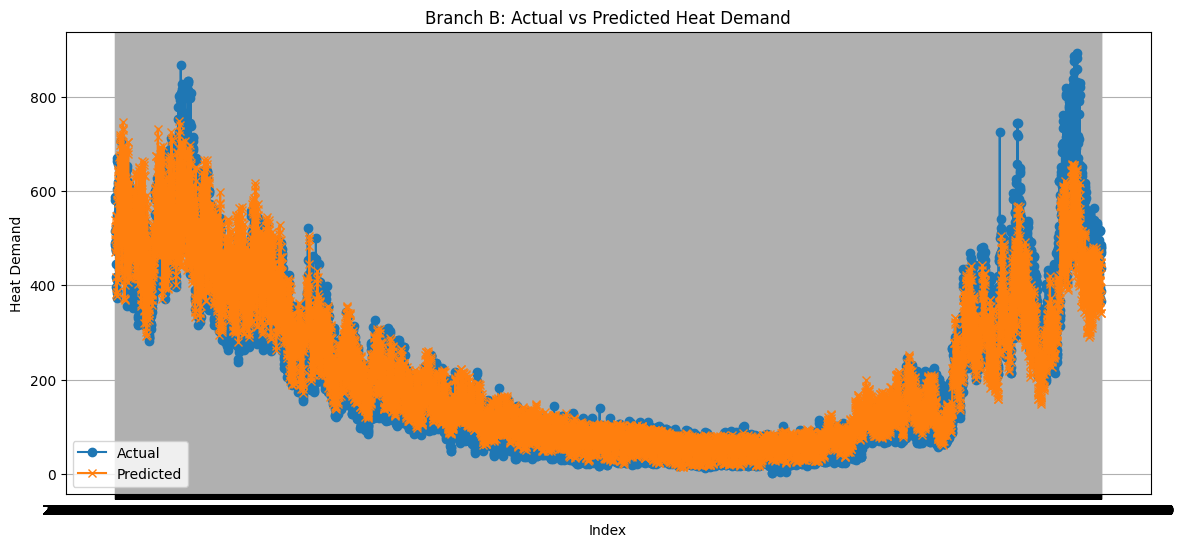

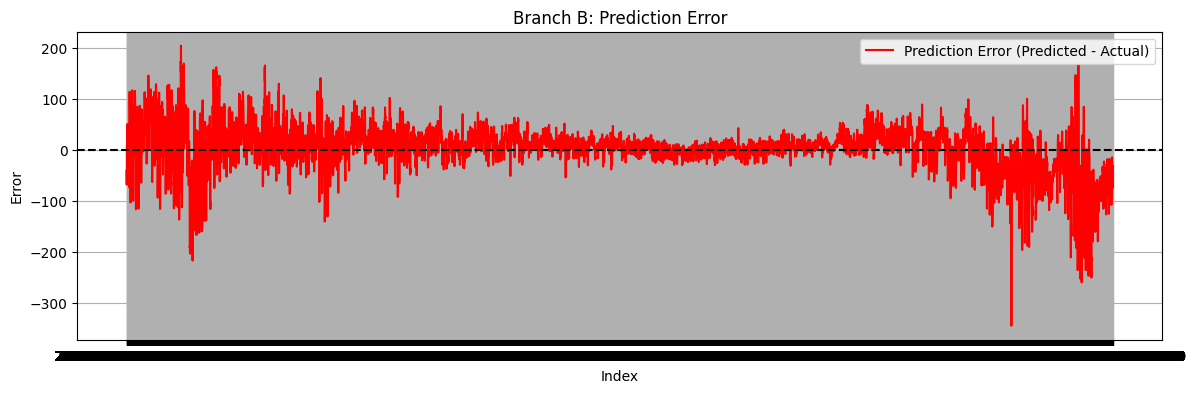

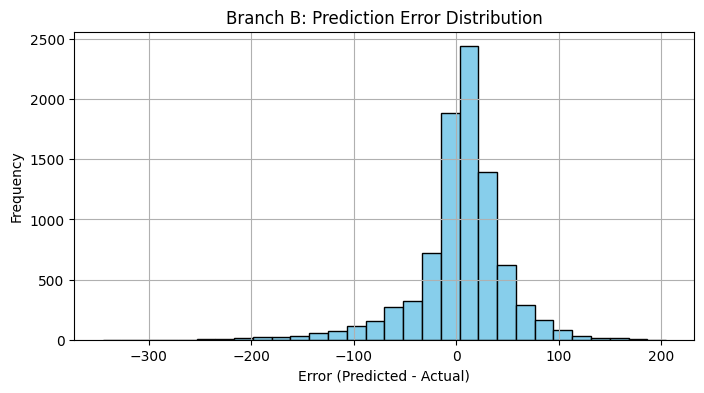

각 Fold의 Validation RMSE: [np.float64(81.98186558352229), np.float64(33.94199106035078)]
최종 평균 Validation RMSE: 57.96192832193654


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 1. branch_id가 'B'인 데이터만 추출
branch = 'B'
train_branch = df_train[df_train['branch_id'] == branch].copy()
test_branch = df_test[df_test['branch_id'] == branch].copy()

# branch_id 컬럼 제거 (모델 입력에 불필요)
train_branch = train_branch.drop(columns=['branch_id'])
test_branch = test_branch.drop(columns=['branch_id'])

target_col = 'heat_demand'

# 2. 예측 수행
results = run_3fold_pipeline_with_residual(train_branch, test_branch, target_col)

# 3. 예측 결과 DataFrame 생성 (index 기준)
test_pred_B = pd.DataFrame({
    'branch_ID': branch,
    'heat_demand': results['test_pred']
}, index=results['test_index'])

# 4. 실제값과 예측값 비교를 위한 df_test_B 준비 (index 기준)
df_test_B = df_test[df_test['branch_id'] == branch].copy()
df_test_B = df_test_B.sort_index()
test_pred_B = test_pred_B.sort_index()

# 5. 공통 인덱스만 사용해서 비교 (NaN 방지)
common_index = df_test_B.index.intersection(test_pred_B.index)
compare_df = df_test_B.loc[common_index, ['heat_demand']].rename(columns={'heat_demand': 'actual'})
compare_df['predicted'] = test_pred_B.loc[common_index, 'heat_demand']
compare_df['diff'] = compare_df['predicted'] - compare_df['actual']

# 6. NaN이 남아있으면 제거
compare_df = compare_df.dropna()

# 7. RMSE, MAE 계산
rmse = np.sqrt(np.mean(compare_df['diff'] ** 2))
mae = np.mean(np.abs(compare_df['diff']))
print(f"Branch B - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# 8. 실제값 vs 예측값 시각화
plt.figure(figsize=(14, 6))
plt.plot(compare_df.index, compare_df['actual'], label='Actual', marker='o')
plt.plot(compare_df.index, compare_df['predicted'], label='Predicted', marker='x')
plt.title('Branch B: Actual vs Predicted Heat Demand')
plt.xlabel('Index')
plt.ylabel('Heat Demand')
plt.legend()
plt.grid(True)
plt.show()

# 9. 오차 시계열 시각화
plt.figure(figsize=(14, 4))
plt.plot(compare_df.index, compare_df['diff'], label='Prediction Error (Predicted - Actual)', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Branch B: Prediction Error')
plt.xlabel('Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# 10. 오차 분포 히스토그램
plt.figure(figsize=(8, 4))
plt.hist(compare_df['diff'], bins=30, color='skyblue', edgecolor='black')
plt.title('Branch B: Prediction Error Distribution')
plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("각 Fold의 Validation RMSE:", results['val_rmses'])
print("최종 평균 Validation RMSE:", results['val_rmse'])

In [9]:
import plotly.graph_objs as go

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['actual'],
    mode='lines+markers', name='Actual', marker=dict(symbol='circle', size=5)
))
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['predicted'],
    mode='lines+markers', name='Predicted', marker=dict(symbol='x', size=5)
))
fig.update_layout(
    title='Branch B: Actual vs Predicted Heat Demand',
    xaxis_title='Index',
    yaxis_title='Heat Demand',
    legend=dict(x=0, y=1),
    template='plotly_white',
    width=900, height=400
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=compare_df.index, y=compare_df['diff'],
    mode='lines+markers', name='Prediction Error', marker=dict(color='red', size=5)
))
fig.add_trace(go.Scatter(
    x=compare_df.index, y=[0]*len(compare_df),  # 0선
    mode='lines', name='Zero Line', line=dict(color='black', dash='dash')
))
fig.update_layout(
    title='Branch B: Prediction Error',
    xaxis_title='Index',
    yaxis_title='Error',
    legend=dict(x=0, y=1),
    template='plotly_white',
    width=900, height=300
)
fig.show()